In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import numpy as np
import pandas as pd

import sys
import os

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

In [2]:
BATCH_SIZE = 1

# setting the correct device to train on
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_device(device)

MAIN_PATH = '/home/u6/njcrutchfield/torch/NN/pill_data/pillQC-main/images' # images are 225 x 225 x 3

tensor_transform = transforms.ToTensor()
horizontal_flip = transforms.RandomHorizontalFlip(p=1)

# Dataset of both normal and horizontal flipped images
dataset = datasets.ImageFolder(MAIN_PATH, transform = tensor_transform) + datasets.ImageFolder(MAIN_PATH, transform=transforms.Compose([
                                                                                                                     tensor_transform,
                                                                                                                     horizontal_flip
                                                                                                                   ]))


In [3]:
SPLIT = [528, 66, 66]
train_set, _, _ = torch.utils.data.random_split(dataset,
                                                SPLIT,# 80%, 10%, 10%
                                                generator=torch.Generator(device=device))

train_loader = torch.utils.data.DataLoader(dataset = train_set,
                                            batch_size = BATCH_SIZE,
                                            shuffle = True,
                                            generator=torch.Generator(device=device))

In [4]:
class Encoder(nn.Module):
    def __init__(self, in_channel=3, out_channel=3500, activation=nn.GELU()):
        super().__init__()
        # The input size is 3*225*225
        self.in_channel = in_channel
        self.out_channel = out_channel
        self.encoder = nn.Sequential(
                                nn.Conv2d(in_channels=in_channel,out_channels=16,kernel_size=3,stride=1,padding=1,bias=False),
                                nn.BatchNorm2d(16), 
                                activation,
            
                                nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=1,padding=1,bias=False),
                                nn.BatchNorm2d(32), 
                                activation,
            
                                nn.Conv2d(in_channels=32,out_channels=32,kernel_size=2,stride=2,padding=1,bias=False),
                                nn.BatchNorm2d(32), 
                                activation,
            
                                nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=1,bias=False),
                                nn.BatchNorm2d(64), 
                                activation,
            
                                nn.Conv2d(in_channels=64,out_channels=64,kernel_size=2,stride=2,padding=1,bias=False),
                                nn.BatchNorm2d(64), 
                                activation,
            
                                nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=1,bias=False),
                                nn.BatchNorm2d(128), 
                                activation,
            
                                nn.Conv2d(in_channels=128,out_channels=128,kernel_size=2,stride=2,padding=1,bias=False),
                                nn.BatchNorm2d(128), 
                                activation,
            
                                nn.Conv2d(in_channels=128,out_channels=320,kernel_size=3,stride=1,padding=1,bias=False),
                                nn.BatchNorm2d(320), 
                                activation,
            
                                nn.Conv2d(in_channels=320,out_channels=240,kernel_size=3,stride=1,padding=1,bias=False),
                                nn.BatchNorm2d(240), 
                                activation,
            
                                nn.Conv2d(in_channels=240,out_channels=150,kernel_size=3,stride=1,padding=1,bias=False),
                                nn.BatchNorm2d(150), 
                                activation,
            
                                nn.Conv2d(in_channels=150,out_channels=80,kernel_size=3,stride=2,padding=1,bias=False),
                                nn.BatchNorm2d(80), 
                                activation,
            
                                nn.Conv2d(in_channels=80,out_channels=40,kernel_size=3,stride=1,padding=1,bias=False),
                                nn.BatchNorm2d(40), 
                                activation,
            
                                nn.Conv2d(in_channels=40,out_channels=15,kernel_size=3,stride=1,padding=1,bias=False),
                                nn.BatchNorm2d(15), 
                                activation,
            
                                nn.Flatten(),
                                nn.Linear(in_features=15*15*15, out_features=out_channel),
                                nn.Softmax(dim=1))
        
    def forward(self, x):
        x = x.view(-1, self.in_channel, 225, 225)
        prob = self.encoder(x)
        return prob


class Decoder(nn.Module):
    def __init__(self, in_channel=3, out_channel=1600, activation=nn.GELU()):
        super().__init__()
        self.in_channel = in_channel
        self.out_channel = out_channel

        self.mlp = nn.Sequential(
                             nn.Linear(in_features=out_channel, out_features=15*15*15, bias=False),
                             nn.BatchNorm1d(15*15*15),
                             activation,
                             nn.Unflatten(1, (15, 15, 15)))
        
        self.decoder = nn.Sequential(
                                nn.ConvTranspose2d(in_channels=15,out_channels=40,kernel_size=3,stride=1,padding=1,output_padding=0,bias=False),
                                nn.BatchNorm2d(40), 
                                activation,
            
                                nn.ConvTranspose2d(in_channels=40,out_channels=80,kernel_size=3,stride=1,padding=1,output_padding=0,bias=False),
                                nn.BatchNorm2d(80), 
                                activation,
            
                                nn.ConvTranspose2d(in_channels=80,out_channels=150,kernel_size=3,stride=2,padding=1,output_padding=0,bias=False),
                                nn.BatchNorm2d(150), 
                                activation,
            
                                nn.ConvTranspose2d(in_channels=150,out_channels=240,kernel_size=3,stride=1,padding=1,output_padding=0,bias=False),
                                nn.BatchNorm2d(240), 
                                activation,
            
                                nn.ConvTranspose2d(in_channels=240,out_channels=320,kernel_size=3,stride=1,padding=1,output_padding=0,bias=False),
                                nn.BatchNorm2d(320), 
                                activation,
            
                                nn.ConvTranspose2d(in_channels=320,out_channels=128,kernel_size=3,stride=1,padding=1,output_padding=0,bias=False),
                                nn.BatchNorm2d(128), 
                                activation,
            
                                nn.ConvTranspose2d(in_channels=128,out_channels=128,kernel_size=3,stride=2,padding=1,output_padding=0,bias=False),
                                nn.BatchNorm2d(128), 
                                activation,
            
                                nn.ConvTranspose2d(in_channels=128,out_channels=64,kernel_size=3,stride=1,padding=1,output_padding=0,bias=False),
                                nn.BatchNorm2d(64), 
                                activation,
            
                                nn.ConvTranspose2d(in_channels=64,out_channels=64,kernel_size=3,stride=2,padding=2,output_padding=0,bias=False),
                                nn.BatchNorm2d(64), 
                                activation,
            
                                nn.ConvTranspose2d(in_channels=64,out_channels=32,kernel_size=3,stride=1,padding=1,output_padding=0,bias=False),
                                nn.BatchNorm2d(32), 
                                activation,
            
                                nn.ConvTranspose2d(in_channels=32,out_channels=32,kernel_size=3,stride=2,padding=1,output_padding=0,bias=False),
                                nn.BatchNorm2d(32), 
                                activation,
            
                                nn.ConvTranspose2d(in_channels=32,out_channels=16,kernel_size=3,stride=1,padding=0,output_padding=0,bias=False),
                                nn.BatchNorm2d(16), 
                                activation,
            
                                nn.ConvTranspose2d(in_channels=16, out_channels=in_channel, kernel_size=3, stride=1, padding=0, output_padding=0),
                                nn.Sigmoid())
    
    def forward(self, x):
        x = x.view(-1, self.out_channel)
        temp = self.mlp(x)
        temp = temp.view(-1,15,15,15)
        output = self.decoder(temp)
        return output

In [5]:
enc_out = 64
encoder = Encoder(out_channel = enc_out)

rand_mat_dim = 32
decoder = Decoder(out_channel = rand_mat_dim)

In [6]:
rand_mat = torch.randn(rand_mat_dim, enc_out, requires_grad=False, device='cuda' if torch.cuda.is_available() else 'cpu')
rand_mat = rand_mat.div(torch.norm(rand_mat, dim = 0))

In [7]:
class AE(torch.nn.Module):
    def __init__(self, encoder, decoder, rand_mat):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.rand_mat = rand_mat
        
    def forward(self, x):
        enc = encoder(x)
        all_dps = []
        for batch in enc:
            all_dps.append(torch.mv(self.rand_mat, batch))
        Dp = torch.stack(all_dps)
        
        p_vec = F.softmax(Dp, dim = 1)
        
        
        
        dec = decoder(p_vec)
        return dec, p_vec

In [8]:
rand_mat

tensor([[-0.1994, -0.0822,  0.1937,  ..., -0.0753, -0.1839, -0.0452],
        [ 0.1148,  0.2247,  0.2497,  ..., -0.2038, -0.1713, -0.2483],
        [ 0.0657, -0.1869,  0.0702,  ..., -0.0606, -0.2305, -0.1344],
        ...,
        [-0.0544,  0.1135,  0.0790,  ...,  0.1573,  0.1083,  0.2150],
        [ 0.0575, -0.0059, -0.3281,  ...,  0.3873,  0.2212,  0.1074],
        [ 0.0859, -0.1636, -0.0506,  ...,  0.0365,  0.4079, -0.1700]],
       device='cuda:0')

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

encoder = Encoder(out_channel = enc_out)
decoder = Decoder(out_channel = rand_mat_dim)
temp = torch.randn(rand_mat_dim, enc_out, requires_grad=False, device='cuda' if torch.cuda.is_available() else 'cpu')
temp = rand_mat.div(torch.norm(rand_mat, dim = 0))

model = AE(encoder, decoder, rand_mat=temp).to(device)
model.load_state_dict(torch.load('./models/scae_model_gs.pth'))
model.rand_mat = torch.load('./models/scae_model_rand_mat.pth')

# setting the encoder and decoder for visualization
encoder = model.encoder
decoder = model.decoder
rand_mat = model.rand_mat

In [10]:
# input and output arrays
encoded_imgs_arr = []
label_arr = []
torch.set_default_device('cuda')

for (inp, label) in train_loader:
    model.eval()
    with torch.no_grad():
        inp = inp.to(device)
        oup, p_vec = model(inp)
        
        # append the p_vec as numpy array, returned as [[]], make into []
        encoded_imgs_arr.append(p_vec.cpu().numpy()[0])
        label_arr.append(label.item())




In [26]:
k = 5
kmeans = KMeans(n_clusters=k)
kmeans.fit(encoded_imgs_arr)
print("Done")

Done


In [27]:
print(f"Sum of squared distance to closest cluster center: {kmeans.inertia_}")

Sum of squared distance to closest cluster center: 0.0001473652960125026


In [28]:
from sklearn.manifold import TSNE

In [29]:
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(encoded_imgs_arr) # fit_transform or fit?

/opt/ohpc/pub/apps/python/3.8.12/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/ohpc/pub/apps/python/3.8.12/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [47]:
col_names = ["X T-SNE", "Y T-SNE", 
             "True Label", "K-means Grouping", "Color T", "Color K"]
df = pd.DataFrame(list(zip(tsne_results[:,0], 
                           tsne_results[:,1], 
                           label_arr, 
                           kmeans.labels_,
                           kmeans.labels_,               # temp for colors
                           kmeans.labels_)),             # temp for colors
                 columns=col_names)

colors = list(mcolors.TABLEAU_COLORS)
for i in range(k):
    df.loc[df["K-means Grouping"] == i, "Color K"] = colors[i]

for i in range(max(label_arr) - min(label_arr) + 1):
    df.loc[df["True Label"] == i, "Color T"] = colors[i]


In [48]:
df.head()

,X T-SNE,Y T-SNE,True Label,K-means Grouping,Color T,Color K
0,-6.518442,32.127979,1,4,tab:orange,tab:purple
1,-15.894335,16.048113,2,1,tab:green,tab:orange
2,-5.183928,14.107293,1,3,tab:orange,tab:red
3,-14.658704,17.846201,2,1,tab:green,tab:orange
4,-37.822273,-13.659406,2,2,tab:green,tab:green


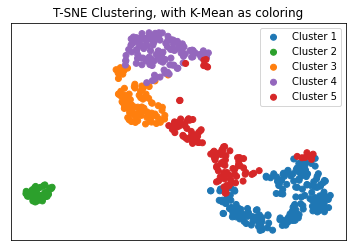

In [46]:
for color, df_group in df.groupby("Color K"):
    plt.scatter(df_group["X T-SNE"], df_group["Y T-SNE"], c=df_group["Color K"], 
                label=f"Feature {color}")
    
plt.xticks([])  
plt.yticks([])
plt.title("T-SNE Clustering, with K-Mean as coloring")

legend_arr = [f"Cluster {i+1}" for i in range(k)]
plt.legend(legend_arr)
plt.show()

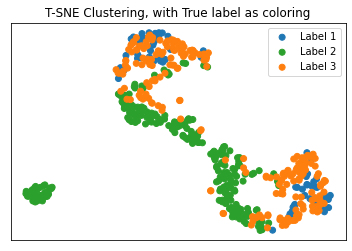

In [55]:
for color, df_group in df.groupby("Color T"):
    plt.scatter(df_group["X T-SNE"], df_group["Y T-SNE"], c=df_group["Color T"], 
                label=f"Feature {color}")
    
plt.xticks([])  
plt.yticks([])
plt.title("T-SNE Clustering, with True label as coloring")

legend_arr = [f"Label {i+1}" for i in range(max(label_arr) - min(label_arr) +1)]
plt.legend(legend_arr)
plt.show()